In [5]:
# !pip install mne
# !pip install PySurfer
# !pip install Scikit-learn
# !pip install llvmpy
# !pip install cython
# !pip install Numba
# !pip install NiBabel
# !pip install Pandas
# !pip install DIPY
# !pip install matplotlib
# !pip install numpy
# !pip install PyVista
# !pip install pyriemann
# !pip install tensorflow-gpu
# !pip install Scipy
# !pip install pyworld
# !pip install librosa==0.7

In [1]:
################ IMPORTS ################
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import gc
import time
from scipy.signal import decimate
from shutil import copyfile
import tensorflow as tf
import mne
from shutil import copyfile
import scipy
from scipy.io.wavfile import write
import librosa
import librosa.display
from mne.filter import filter_data
from scipy.signal import decimate, hilbert
from scipy import fftpack
import scipy.io.wavfile as wavefile
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *

In [65]:
################ SETTING PARAMETERS ################
window_size = 10  # ms
input_shape = (window_size, 107, 1)  # window_size x n_sensors
lrelu_a = 0.2
brain_samp_freq = 1024
audio_samp_freq = 48000
audio_target_freq = 16000
audio_to_brain_diff = audio_target_freq/brain_samp_freq

In [90]:
################ READING DATA ################

storage_dir = '../seeg_data/'
extracted_features_dir = storage_dir+'extracted_features/'

skip_seconds = 10
take_seconds = skip_seconds + 3000

#Reading data files
data_original = np.load(storage_dir+"kh1_1_sEEG.npy")[brain_samp_freq*skip_seconds:brain_samp_freq*take_seconds] # Columns=channels, Rows=timesteps
ch_names = np.load(storage_dir+"kh1_1_channelNames.npy")   # Names of channels
audio = np.load(storage_dir+"kh1_1_audio.npy")[audio_samp_freq*skip_seconds:audio_samp_freq*take_seconds]   # Audio
words = np.array(np.load(storage_dir+"kh1_1_words.npy"))[brain_samp_freq*skip_seconds:brain_samp_freq*take_seconds]# Words
# activated_audio = np.load(extracted_features_dir+"kh1_1_activated_audio.npy")

timesteps, n_channels = data_original.shape
audio_resampled=librosa.core.resample(audio, audio_samp_freq, audio_target_freq)[:-15]



In [91]:
################ PREPROCESS DATA ################
activated_audio = (np.abs(audio_resampled) > 0.005)
unique_words = list(set(words))

# print(len(audio_resampled)/len(words))
print(len(audio_resampled))
print(len(words))
# print(audio_resampled.max())

current_word = ''
word_start = audio_resampled.shape[0]
word_end = -1
for i in range(0, len(activated_audio) - 1, 1):
  word_index = min(int(i/audio_to_brain_diff), words.shape[0] - 1)
  if word_index > words.shape[0]:
      print('exceeded')

  corresponding_word = words[word_index]

  if corresponding_word == '':
      continue

  if corresponding_word != current_word:
    current_word = corresponding_word
    for j in range(word_start, word_end):
      activated_audio[word_start:word_end] = True
    word_start = -1
  else:
    if activated_audio[i]:
      if word_start == -1:
        word_start = i
      word_end = i

if word_end > -1:
  for j in range(word_start, word_end):
      activated_audio[min(j, activated_audio.shape[0] - 1)] = True

# print(word_start, word_end)

# print(words)

# (word_activation == False).any()

4677024
299329


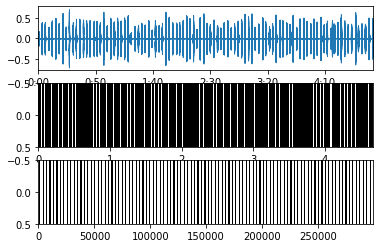

In [92]:
################ VISUALISE AUDIO ################
fig, (ax_wave, ax_activation, ax_word_activation) = plt.subplots(3)

librosa.display.waveplot(audio_resampled, sr=audio_target_freq, ax=ax_wave)
# ax_activation.imshow((np.array(words)!='').reshape(1, words.shape[0]), aspect='auto', cmap=plt.cm.gray, interpolation='nearest' )
ax_activation.imshow(activated_audio.reshape(1, activated_audio.shape[0]), aspect='auto', cmap=plt.cm.gray, interpolation='nearest' )
ax_word_activation.imshow((words != '').reshape(1, words.shape[0]), aspect='auto', cmap=plt.cm.gray, interpolation='nearest' )
plt.show()

In [46]:
################ SAVE AUDIO ################
write(extracted_features_dir+'kh1_1_audio', audio_target_freq, audio_resampled)

In [ ]:
################ SAVE ACTIVATED AUDIO ################
np.save(extracted_features_dir+'kh1_1_activated_audio', activated_audio)


In [96]:
################ SPLIT DATA ################
def extract_high_gamma(data, sr):
    hilbert3 = lambda x: hilbert(x, fftpack.next_fast_len(len(x)),axis=0)[:len(x)]
    #Linear detrend
    data = scipy.signal.detrend(data,axis=0)
    #Filtering
    data = filter_data(data.T, sr, 70,170,method='iir').T
    data = filter_data(data.T, sr, 102, 98,method='iir').T # Band-stop
    data = filter_data(data.T, sr, 152, 148,method='iir').T
    data = np.abs(hilbert3(data))
    return data

data_original_hg = data_original
# data_original_hg = extract_high_gamma(data_original, brain_samp_freq)

X = []
Y = []

ms_offset = 50
window_size_ms = window_size/1000
n_brain_samples = int(window_size_ms*brain_samp_freq)
for i in range(0, data_original.shape[0], n_brain_samples):
  y_index = min(int(i * audio_to_brain_diff + (audio_target_freq * (ms_offset / 1000))) , activated_audio.shape[0] -1)
  x = data_original_hg[i:i+n_brain_samples]
  y = activated_audio[y_index]
  if x.shape != (n_brain_samples, 107):
    continue
  X.append(x.reshape(input_shape))
  Y.append(int(y))

X = np.array(X)
Y = np.array(Y)

print(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=True)

print(X_train.shape)
print(y_train.shape)



[1 1 1 ... 0 0 0]
(26938, 10, 107, 1)
(26938,)


In [97]:
################ CREATING MODEL ################
def build_model():
  m_input = Input(
      shape=input_shape,
      name='c_input'
  )

  C1 = Conv2D(
      filters=512,
      kernel_size=3,
      strides=1,
      padding='same',
      name='C1'
  )(m_input)

  C1 = LeakyReLU(lrelu_a)(C1)
  C1 = BatchNormalization()(C1)

  C2 = Conv2D(
      filters=256,
      kernel_size=3,
      strides=1,
      padding='same',
      name='C2'
  )(C1)

  C2 = LeakyReLU(lrelu_a)(C2)
  C2 = BatchNormalization()(C2)

  C3 = Conv2D(
      filters=128,
      kernel_size=3,
      strides=1,
      padding='same',
      name='C3'
  )(C2)

  C3 = LeakyReLU(lrelu_a)(C3)
  C3 = BatchNormalization()(C3)

  C4 = Conv2D(
      filters=64,
      kernel_size=2,
      strides=1,
      padding='valid',
      name='C4',
  )(C3)

  C4 = LeakyReLU(lrelu_a)(C4)
  C4 = BatchNormalization()(C4)

  C4 = Flatten()(C4)

  D1 = Dense(128)(C4)

  # D1 = LeakyReLU(lrelu_a)(D1)

  D2 = Dense(1, activation='sigmoid')(D1)

  return tf.keras.Model(inputs=m_input, outputs=D2, name='SilenceClassifier')

model = build_model()  # Classifier

model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)


Model: "SilenceClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c_input (InputLayer)         [(None, 10, 107, 1)]      0         
_________________________________________________________________
C1 (Conv2D)                  (None, 10, 107, 512)      5120      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 10, 107, 512)      0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 10, 107, 512)      2048      
_________________________________________________________________
C2 (Conv2D)                  (None, 10, 107, 256)      1179904   
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 10, 107, 256)      0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 10, 107, 256)

In [95]:
################ TRAINING ################
unique, counts = np.unique(activated_audio, return_counts=True)
dict(zip(unique, counts))
neg_weight = (1/counts[0]) * (activated_audio.shape[0])/2.0
pos_weight = (1/counts[1]) * (activated_audio.shape[0])/2.0

model.fit(
    X_train, y_train, epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight={False: neg_weight, True: pos_weight},
)


Epoch 1/10
421/421 [==============================] - 25s 60ms/step - loss: 2.3109 - accuracy: 0.7399 - val_loss: 0.4260 - val_accuracy: 0.836
Epoch 2/10
421/421 [==============================] - 25s 60ms/step - loss: 0.3533 - accuracy: 0.8482 - val_loss: 0.2113 - val_accuracy: 0.91
Epoch 3/10
421/421 [==============================] - 26s 61ms/step - loss: 0.2938 - accuracy: 0.8734 - val_loss: 0.2974 - val_accuracy: 0.87
Epoch 4/10
421/421 [==============================] - 25s 60ms/step - loss: 0.2783 - accuracy: 0.8814 - val_loss: 0.3047 - val_accuracy: 0.882
Epoch 5/10
421/421 [==============================] - 25s 60ms/step - loss: 0.2729 - accuracy: 0.8822 - val_loss: 0.3896 - val_accuracy: 0.84
Epoch 6/10
421/421 [==============================] - 26s 61ms/step - loss: 0.2542 - accuracy: 0.8896 - val_loss: 0.3300 - val_accuracy: 0.87
Epoch 7/10
421/421 [==============================] - 26s 62ms/step - loss: 0.2561 - accuracy: 0.8913 - val_loss: 0.4435 - val_accuracy: 0.82
Epoc

In [ ]:
################ TEMP ################

unique, counts = np.unique(activated_audio, return_counts=True)
dict(zip(unique, counts))

print((1/counts[0]) * (activated_audio.shape[0])/2.0)
print((1/counts[1]) * (activated_audio.shape[0])/2.0)